In [24]:
import os
from PIL import Image
import torch
import cv2
import re
import numpy as np
import openai

from langchain_openai import ChatOpenAI 
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import  FAISS
from langchain_core.tools import tool
from langchain.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain
import pytz
from langchain_core.runnables import RunnableConfig

from time import monotonic
from dotenv import load_dotenv
from pprint import pprint
import os
from datasets import Dataset
from typing_extensions import TypedDict
from IPython.display import display, Image
from typing import List, TypedDict

from helper_functions import num_tokens_from_string, replace_t_with_space, replace_double_lines_with_one_line, split_into_chapters,\
analyse_metric_results, escape_quotes, text_wrap,extract_book_quotes_as_documents


In [25]:
os.environ["OPENAI_API_KEY"] = ""
groq_api_key = ""

guides_path='IICRC.pdf'

In [26]:
chapters = split_into_chapters(guides_path, start_page=89)
chapters = replace_t_with_space(chapters)
print(len(chapters))

17


In [27]:
summarization_prompt_template = """Write an extensive summary of the following, maintain headings as they're important:

{text}

SUMMARY:"""

summarization_prompt = PromptTemplate(template=summarization_prompt_template, input_variables=["text"])

In [28]:
def create_chapter_summary(chapter):
    """
    Creates a summary of a chapter using a large language model (LLM).

    Args:
        chapter: A Document object representing the chapter to summarize.

    Returns:
        A Document object containing the summary of the chapter.
    """

    chapter_txt = chapter.page_content  # Extract chapter text
    model_name = "gpt-4o"  # Specify LLM model
    llm = ChatOpenAI(temperature=0, model_name=model_name)  # Create LLM instance
    gpt_35_turbo_max_tokens = 16000  # Maximum token limit for the LLM
    verbose = False  # Set to True for more detailed output

    # Calculate number of tokens in the chapter text
    num_tokens = num_tokens_from_string(chapter_txt, model_name)

    # Choose appropriate chain type based on token count
    if num_tokens < gpt_35_turbo_max_tokens:
        chain = load_summarize_chain(llm, chain_type="stuff", prompt=summarization_prompt, verbose=verbose) 
    else:
        chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=summarization_prompt, combine_prompt=summarization_prompt, verbose=verbose)

    start_time = monotonic()  # Start timer
    doc_chapter = Document(page_content=chapter_txt)  # Create Document object for chapter
    summary = chain.invoke([doc_chapter])  # Generate summary using the chain
    print(f"Chain type: {chain.__class__.__name__}")  # Print chain type
    print(f"Run time: {monotonic() - start_time}")  # Print execution time

    summary = replace_double_lines_with_one_line(summary["output_text"])
    summary_text = "\n".join(summary)

    doc_summary = Document(page_content=summary_text, metadata=chapter.metadata)

    return doc_summary

In [29]:
preliminary_inspection_chapter = [chapters[9]]
preliminary_inspection_chapter2 = chapters[9]
preliminary_inspection_summary = create_chapter_summary(preliminary_inspection_chapter2)
preliminary_inspection_summary

Chain type: StuffDocumentsChain
Run time: 17.096964400999923


Document(metadata={'chapter': 10}, page_content="### \nChapter 10\n: Inspections, Preliminary Determination, and Pre-Restoration Evaluations\n\n#### INTRODUCTION\nIn the initial stages of a restoration project, restorers face the challenge of deciding between immediate action to remove water and start drying, and the need to identify and control hazards and contaminants. Key activities at the project's start include information gathering, initial response, safety and health issue resolution, pre-restoration inspection, preliminary determination, pre-restoration evaluations, and work planning. The ANSI/IICRC S500 Standard provides guidelines for safely restoring water-damaged properties, emphasizing that processes may not always follow a linear progression and can vary based on project circumstances.\n\n#### QUALIFICATIONS\nRestorers must be qualified through education, training, certification, and experience to perform core skills. They should only provide services they are licensed or

In [30]:
restoration_chapter = [chapters[12]]

In [31]:
def encode_restoration_chapter(restoration_chapter):
    """
    Encodes a list of chapter summaries into a vector store using OpenAI embeddings.

    Args:
        chapter_summaries: A list of Document objects representing the chapter summaries.

    Returns:
        A FAISS vector store containing the encoded chapter summaries.
    """

    embeddings = OpenAIEmbeddings()  # Create OpenAI embeddings
    restoration_vectorstore = FAISS.from_documents(restoration_chapter, embeddings)  # Create vector store
    return restoration_vectorstore

In [32]:
def encode_preliminary_inspection_chapter(preliminary_inspection_chapter):
    """
    Encodes a list of chapter summaries into a vector store using OpenAI embeddings.

    Args:
        chapter_summaries: A list of Document objects representing the chapter summaries.

    Returns:
        A FAISS vector store containing the encoded chapter summaries.
    """

    embeddings = OpenAIEmbeddings()  # Create OpenAI embeddings
    preliminary_inspection_vectorstore = FAISS.from_documents(preliminary_inspection_chapter, embeddings)  # Create vector store
    return preliminary_inspection_vectorstore

In [33]:
def encode_book(path, chunk_size=10000, chunk_overlap=200):
    """
    Encodes a PDF book into a vector store using OpenAI embeddings.

    Args:
        path: The path to the PDF file.
        chunk_size: The desired size of each text chunk.
        chunk_overlap: The amount of overlap between consecutive chunks.

    Returns:
        A FAISS vector store containing the encoded book content.
    """

    # Load PDF documents
    loader = PyPDFLoader(path)
    documents = loader.load()

    # Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len
    )
    texts = text_splitter.split_documents(documents)
    cleaned_texts = replace_t_with_space(texts)

    # Create embeddings and vector store
    embeddings = OpenAIEmbeddings()
    vectorstore = FAISS.from_documents(cleaned_texts, embeddings)

    return vectorstore

In [34]:
from pydantic import BaseModel, Field, validator
from typing import List, Dict, Union

# Define the input schema for the multimodal inference tool
class MultimodalQuery(BaseModel):
    text: str = Field(..., description="The prompt or text query for the inference.")
    files: List[Dict[str, str]] = Field(..., description="A list of files. Each file must have a 'path'.")

    # Validator to ensure each file has a valid path
    @validator('files', each_item=True)
    def check_file_structure(cls, v):
        if 'path' not in v:
            raise ValueError("Each file entry must contain a 'path'.")
        return v

# Define the StructuredTool implementation
@tool
def multimodal_inference(query: MultimodalQuery) -> str:
    """
    Performs multimodal inference using LLaVA with input text and either images or videos.
    
    Args:
        query (MultimodalQuery): A validated dictionary containing 'text' for the prompt and 'files', 
                                 which is a list of image files or video files.
        
    Returns:
        str: The generated output based on the text and visual input.
    """
    text = query.text
    files = query.files

    if files:
        image_files = [msg['path'] for msg in files]
    else:
        raise ValueError("You need to upload an image or video for LLaVA to work.")

    video_extensions = ("avi", "mp4", "mov", "mkv", "flv", "wmv", "mjpeg")
    image_extensions = ('.blp', '.bmp', '.dib', '.bufr', '.cur', '.pcx', '.dcx', '.dds', '.ps', '.eps', 
                        '.fit', '.fits', '.fli', '.flc', '.ftc', '.ftu', '.gbr', '.gif', '.grib', 
                        '.h5', '.hdf', '.png', '.apng', '.jp2', '.j2k', '.jpc', '.jpf', '.jpx', 
                        '.j2c', '.icns', '.ico', '.im', '.iim', '.jfif', '.jpe', '.jpg', '.jpeg', 
                        '.mpg', '.mpeg', '.tif', '.tiff', '.mpo', '.msp', '.palm', '.pcd', '.pdf', 
                        '.pxr', '.pbm', '.pgm', '.ppm', '.pnm', '.pfm', '.psd', '.qoi', '.bw', 
                        '.rgb', '.rgba', '.sgi', '.ras', '.tga', '.icb', '.vda', '.vst', '.webp', 
                        '.wmf', '.emf', '.xbm', '.xpm')

    if len(image_files) == 1:
        if image_files[0].endswith(video_extensions):
            # Process video and sample frames
            image = sample_frames(image_files[0], 12)
            image_tokens = "<image>" * 13
            prompt = f"<|im_start|>user {image_tokens}\n{text}<|im_end|><|im_start|>assistant"
        elif image_files[0].endswith(image_extensions):
            image = Image.open(image_files[0]).convert("RGB")
            prompt = f"<|im_start|>user <image> The response to the query must be in very great detail \n{text}<|im_end|><|im_start|>assistant"
    elif len(image_files) > 1:
        # Process multiple images/videos
        image_list = []
        for img in image_files:
            if img.endswith(image_extensions):
                img = Image.open(img).convert("RGB")
                image_list.append(img)
            elif img.endswith(video_extensions):
                frames = sample_frames(img, 6)
                image_list.extend(frames)

        toks = "<image>" * len(image_list)
        prompt = f"<|im_start|>user {toks}\n{text}<|im_end|><|im_start|>assistant"
        image = image_list

    inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda", torch.float16)
    output = multimodal_model.generate(**inputs, max_new_tokens=200, do_sample=False)
    generated_output = processor.decode(output[0][2:], skip_special_tokens=True)
    return generated_output

@tool
def categorize_class(query: str) -> str:
    """
    Categorizes the given information about building damages into a specific category (Fire, Water, or General).
    
    Args:
        query (str): The description of building damage to be categorized.
        
    Returns:
        dict: A dictionary containing the category of the damage.
    """
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following information about building damages into one of these categories: "
        "Fire, Water, General. Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    category = chain.invoke({"query": query}).content
    return {"category": category}

@tool
def create_objectives(query: str) -> str:
    """
    Creates objectives for restoring building damages based on a specific category (Fire, Water, or General).
    
    Args:
        query (str): The description of building damage to generate restoration objectives.
        
    Returns:
        dict: A dictionary containing the objectives for restoring the damages.
    """
    prompt = ChatPromptTemplate.from_template(
        "Create objectives for restoring building damages categorized as: Fire, Water, General. Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    objectives = chain.invoke({"query": query}).content
    return {"objectives": objectives}

@tool
def book_lookup(query: str) -> str:
    """
    Looks up relevant content in a pre-chunked book stored in FAISS based on the given query.
    
    Args:
        query (str): The query to search for in the book chunks.
        
    Returns:
        str: The most relevant content found in the book based on the query.
    """
    vector_store_path = "chunks_vector_store"
    if os.path.exists(vector_store_path):
        embeddings = OpenAIEmbeddings()
        chunks_vector_store = FAISS.load_local(vector_store_path, embeddings, allow_dangerous_deserialization=True)
    else:
        chunks_vector_store = encode_book(guides_path, chunk_size=10000, chunk_overlap=200)
        chunks_vector_store.save_local(vector_store_path)

    chunks_query_retriever = chunks_vector_store.as_retriever(search_kwargs={"k": 1})
    search_results = chunks_query_retriever.invoke(query)
    if search_results:
        return search_results[0].page_content  
    else:
        return "No relevant content found."

@tool
def preliminary_chapter_lookup(query: str) -> str:
    """
    Looks up relevant content in a pre-chunked book stored in FAISS based on the given query.
    
    Args:
        query (str): The query to search for in the book chunks.
        
    Returns:
        str: The most relevant content found in the book based on the query.
    """
    vector_store_path = "preliminary_vector_store"
    
    # Load or encode the vector store based on the presence of the FAISS index
    if os.path.exists(vector_store_path):
        embeddings = OpenAIEmbeddings()
        preliminary_inspection_vectorstore = FAISS.load_local(
            vector_store_path, embeddings, allow_dangerous_deserialization=True
        )
    else:
        preliminary_inspection_vectorstore = encode_preliminary_inspection_chapter(preliminary_inspection_chapter)
        preliminary_inspection_vectorstore.save_local(vector_store_path)

    # Set up a retriever to fetch the most relevant chunk
    preliminary_query_retriever = preliminary_inspection_vectorstore.as_retriever(search_kwargs={"k": 1})
    search_results = preliminary_query_retriever.invoke(query)
    if search_results:
        return search_results[0].page_content  
    else:
        return "No relevant content found."

@tool
def restoration_chapter_lookup(query: str) -> str:
    """
    Looks up relevant content in a pre-chunked book stored in FAISS based on the given query.
    
    Args:
        query (str): The query to search for in the book chunks.
        
    Returns:
        str: The most relevant content found in the book based on the query.
    """
    vector_store_path = "restoration_vector_store"
    
    # Load or encode the vector store based on the presence of the FAISS index
    if os.path.exists(vector_store_path):
        embeddings = OpenAIEmbeddings()
        restoration_chapter_vectorstore = FAISS.load_local(
            vector_store_path, embeddings, allow_dangerous_deserialization=True
        )
    else:
        restoration_chapter_vectorstore = encode_restoration_chapter(restoration_chapter)
        restoration_chapter_vectorstore.save_local(vector_store_path)

    # Set up a retriever to fetch the most relevant chunk
    restoration_query_retriever = restoration_chapter_vectorstore.as_retriever(search_kwargs={"k": 1})
    search_results = restoration_query_retriever.invoke(query)

    # Return the most relevant result if available
    if search_results:
        return search_results[0].page_content  
    else:
        return "No relevant content found."

/tmp/ipykernel_9106/3131897520.py:10: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
  @validator('files', each_item=True)


In [35]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=float('inf')):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [36]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [37]:
from datetime import datetime
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
# You could swap LLMs, though you will likely want to update the prompts when
# doing so!
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4-turbo-preview")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an intelligent building restoration copilot, designed to assist restoration engineers with structural damage restoration tasks. "
            "You will follow a structured process to gather context, categorize damage, and interactively retrieve and provide step-by-step guidance during restoration efforts. "
            "Make sure to provide an output after every tool call, and also ask the user questions"
            "Your workflow should adhere to the following structure:"
            "**Context Gathering from Multimodal Model:** "
            "- Use the multimodal model to gather context from images or videos provided by the user if available. If the input is text-only, analyze the provided text."
            "- Summarize the gathered information before proceeding."
            "\n\n2. **Input Example:** "
            "The input will be in dictionary format, where the 'text' field contains a description of the task or question, and the 'files' field contains optional media files (images or videos). If no media files are provided, only the text will be used for analysis."
            "\n\nIf only text is provided, use the text to infer appropriate tools."
            "\n\n3. **Categorize the Damage Class:** "
            "- After gathering context, categorize the type of damage into one of three categories: Water, Fire, or General."
            "- Provide initial guidance on restoration procedures based on the categorization."
            "\n\n4. **Interactive Preliminary Objectives:** "
            "- Use the `preliminary_chapter_lookup` tool to retrieve relevant steps for preliminary inspection based on the damage type, don't just output the objectives, relate them to what the user is experiencing. " 
            "- this should be interactive, whereby you ask questions from the user based on the current objective to know if the preliminary objective has been fulfilled or not "
            "\n\n5. **Restoration Process Retrieval:** "
            "- Use the `restoration_chapter_lookup` tool to retrieve detailed restoration steps."
            "- Make sure the restoration steps go along with whatever damage you have detected, do not present generic restoration procedures."
            "- Present the restoration steps interactively and allow the user to request further clarifications."
            "\n\nThroughout the process, make sure to interactively assist the user, ask for clarifications when needed, and align with the IICRC guidelines."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_1_tools = [categorize_class,
                create_objectives,
                preliminary_chapter_lookup,
                restoration_chapter_lookup,
                book_lookup,
                multimodal_inference
                ]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

In [38]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.

In [39]:
# import shutil
# import uuid

# # Define a single question
# question = """The building in the image appears to be abandoned and in a state of disrepair.
# The walls are covered in a layer of debris and paint, and the floor is flooded with water. 
# The windows are boarded up, and there are signs of graffiti on the walls. 
# The ceiling is also covered in debris, and the lighting is dim. 
# The overall condition of the building suggests that it has been abandoned for a significant amount of time. 
# The presence of water on the floor indicates that there may have been flooding in the building. 
# The graffiti on the walls suggests that the building may have been used for illegal activities or as a meeting place for gang members. 
# The overall condition of the building indicates that it has been neglected and abandoned for a long time.

# Guide me towards restoration of the building"""
# # Generate a unique thread_id and user_id
# thread_id = str(uuid.uuid4())
# config = {
#     "configurable": {
#         "user_id": str(uuid.uuid4()),
#         "thread_id": thread_id,
#     }
# }

# _printed = set()

# # Simulate multi-turn conversation using a loop for one question
# while True:
#     print(f"User: {question}")  # Display the user question
    
#     # Pass the single question to the event loop
#     events = part_1_graph.stream(
#         {"messages": ("user", question)}, config, stream_mode="values"
#     )
    
#     # Simulate the system's response for each event
#     for event in events:
#         _print_event(event, _printed)  # Assuming _print_event handles the event output
    
#     print("-------")  # Divider between each round for clarity

#     # Prompt for the next user question or action to continue the conversation
#     question = input("Enter your next question or action: ")


In [40]:

# # Generate unique identifiers for the session
# thread_id = str(uuid.uuid4())
# config = {
#     "configurable": {
#         "user_id": str(uuid.uuid4()),
#         "thread_id": thread_id,
#     }
# }

# # Display the user question for context
# print(f"User Input: {input_state['messages']} | Media Files: {input_state['media_files']}")

# # Pass the input into the graph
# events = part_1_graph.stream(
#     {"messages": input_state["messages"], "media_files": input_state["media_files"]},
#     config,
# )

# print(events)
# for event in events:
#     print(event)
# # # Simulate the system's response for each event
# # _printed = set()
# # for event in events:
# #     _print_event(event, _printed)  # Handle the event output

# for output in part_1_graph.stream(
#         {"messages": input_state["messages"], "media_files": input_state["media_files"]},
#     config,
#     ):
#         last_message = next(iter(output.values()))["messages"][-1]
#         last_message.pretty_print()

# if output and "prompt" in output:
#     print("Done!")

In [41]:
"""Implementation of a langgraph checkpoint saver using Redis."""
from contextlib import asynccontextmanager, contextmanager
from typing import (
    Any,
    AsyncGenerator,
    AsyncIterator,
    Iterator,
    List,
    Optional,
    Tuple,
)

from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.base import (
    BaseCheckpointSaver,
    ChannelVersions,
    Checkpoint,
    CheckpointMetadata,
    CheckpointTuple,
    PendingWrite,
    get_checkpoint_id,
)
from langgraph.checkpoint.serde.base import SerializerProtocol
from redis import Redis
from redis.asyncio import Redis as AsyncRedis

REDIS_KEY_SEPARATOR = ":"


# Utilities shared by both RedisSaver and AsyncRedisSaver


def _make_redis_checkpoint_key(
    thread_id: str, checkpoint_ns: str, checkpoint_id: str
) -> str:
    return REDIS_KEY_SEPARATOR.join(
        ["checkpoint", thread_id, checkpoint_ns, checkpoint_id]
    )


def _make_redis_checkpoint_writes_key(
    thread_id: str,
    checkpoint_ns: str,
    checkpoint_id: str,
    task_id: str,
    idx: Optional[int],
) -> str:
    if idx is None:
        return REDIS_KEY_SEPARATOR.join(
            ["writes", thread_id, checkpoint_ns, checkpoint_id, task_id]
        )

    return REDIS_KEY_SEPARATOR.join(
        ["writes", thread_id, checkpoint_ns, checkpoint_id, task_id, str(idx)]
    )


def _parse_redis_checkpoint_key(redis_key: str) -> dict:
    namespace, thread_id, checkpoint_ns, checkpoint_id = redis_key.split(
        REDIS_KEY_SEPARATOR
    )
    if namespace != "checkpoint":
        raise ValueError("Expected checkpoint key to start with 'checkpoint'")

    return {
        "thread_id": thread_id,
        "checkpoint_ns": checkpoint_ns,
        "checkpoint_id": checkpoint_id,
    }


def _parse_redis_checkpoint_writes_key(redis_key: str) -> dict:
    namespace, thread_id, checkpoint_ns, checkpoint_id, task_id, idx = redis_key.split(
        REDIS_KEY_SEPARATOR
    )
    if namespace != "writes":
        raise ValueError("Expected checkpoint key to start with 'checkpoint'")

    return {
        "thread_id": thread_id,
        "checkpoint_ns": checkpoint_ns,
        "checkpoint_id": checkpoint_id,
        "task_id": task_id,
        "idx": idx,
    }


def _filter_keys(
    keys: List[str], before: Optional[RunnableConfig], limit: Optional[int]
) -> list:
    """Filter and sort Redis keys based on optional criteria."""
    if before:
        keys = [
            k
            for k in keys
            if _parse_redis_checkpoint_key(k.decode())["checkpoint_id"]
            < before["configurable"]["checkpoint_id"]
        ]

    keys = sorted(
        keys,
        key=lambda k: _parse_redis_checkpoint_key(k.decode())["checkpoint_id"],
        reverse=True,
    )
    if limit:
        keys = keys[:limit]
    return keys


def _dump_writes(serde: SerializerProtocol, writes: tuple[str, Any]) -> list[dict]:
    """Serialize pending writes."""
    serialized_writes = []
    for channel, value in writes:
        type_, serialized_value = serde.dumps_typed(value)
        serialized_writes.append(
            {"channel": channel, "type": type_, "value": serialized_value}
        )
    return serialized_writes


def _load_writes(
    serde: SerializerProtocol, task_id_to_data: dict[tuple[str, str], dict]
) -> list[PendingWrite]:
    """Deserialize pending writes."""
    writes = [
        (
            task_id,
            data[b"channel"].decode(),
            serde.loads_typed((data[b"type"].decode(), data[b"value"])),
        )
        for (task_id, _), data in task_id_to_data.items()
    ]
    return writes


def _parse_redis_checkpoint_data(
    serde: SerializerProtocol,
    key: str,
    data: dict,
    pending_writes: Optional[List[PendingWrite]] = None,
) -> Optional[CheckpointTuple]:
    """Parse checkpoint data retrieved from Redis."""
    if not data:
        return None

    parsed_key = _parse_redis_checkpoint_key(key)
    thread_id = parsed_key["thread_id"]
    checkpoint_ns = parsed_key["checkpoint_ns"]
    checkpoint_id = parsed_key["checkpoint_id"]
    config = {
        "configurable": {
            "thread_id": thread_id,
            "checkpoint_ns": checkpoint_ns,
            "checkpoint_id": checkpoint_id,
        }
    }

    checkpoint = serde.loads_typed((data[b"type"].decode(), data[b"checkpoint"]))
    metadata = serde.loads(data[b"metadata"].decode())
    parent_checkpoint_id = data.get(b"parent_checkpoint_id", b"").decode()
    parent_config = (
        {
            "configurable": {
                "thread_id": thread_id,
                "checkpoint_ns": checkpoint_ns,
                "checkpoint_id": parent_checkpoint_id,
            }
        }
        if parent_checkpoint_id
        else None
    )
    return CheckpointTuple(
        config=config,
        checkpoint=checkpoint,
        metadata=metadata,
        parent_config=parent_config,
        pending_writes=pending_writes,
    )

In [42]:
class RedisSaver(BaseCheckpointSaver):
    """Redis-based checkpoint saver implementation."""

    conn: Redis

    def __init__(self, conn: Redis):
        super().__init__()
        self.conn = conn

    @classmethod
    @contextmanager
    def from_conn_info(cls, *, host: str, port: int, db: int) -> Iterator["RedisSaver"]:
        conn = None
        try:
            conn = Redis(host=host, port=port, db=db)
            yield RedisSaver(conn)
        finally:
            if conn:
                conn.close()

    def put(
        self,
        config: RunnableConfig,
        checkpoint: Checkpoint,
        metadata: CheckpointMetadata,
        new_versions: ChannelVersions,
    ) -> RunnableConfig:
        """Save a checkpoint to Redis.

        Args:
            config (RunnableConfig): The config to associate with the checkpoint.
            checkpoint (Checkpoint): The checkpoint to save.
            metadata (CheckpointMetadata): Additional metadata to save with the checkpoint.
            new_versions (ChannelVersions): New channel versions as of this write.

        Returns:
            RunnableConfig: Updated configuration after storing the checkpoint.
        """
        thread_id = config["configurable"]["thread_id"]
        checkpoint_ns = config["configurable"]["checkpoint_ns"]
        checkpoint_id = checkpoint["id"]
        parent_checkpoint_id = config["configurable"].get("checkpoint_id")
        key = _make_redis_checkpoint_key(thread_id, checkpoint_ns, checkpoint_id)

        type_, serialized_checkpoint = self.serde.dumps_typed(checkpoint)
        serialized_metadata = self.serde.dumps(metadata)
        data = {
            "checkpoint": serialized_checkpoint,
            "type": type_,
            "metadata": serialized_metadata,
            "parent_checkpoint_id": parent_checkpoint_id
            if parent_checkpoint_id
            else "",
        }
        self.conn.hset(key, mapping=data)
        return {
            "configurable": {
                "thread_id": thread_id,
                "checkpoint_ns": checkpoint_ns,
                "checkpoint_id": checkpoint_id,
            }
        }

    def put_writes(
        self,
        config: RunnableConfig,
        writes: List[Tuple[str, Any]],
        task_id: str,
    ) -> RunnableConfig:
        """Store intermediate writes linked to a checkpoint.

        Args:
            config (RunnableConfig): Configuration of the related checkpoint.
            writes (Sequence[Tuple[str, Any]]): List of writes to store, each as (channel, value) pair.
            task_id (str): Identifier for the task creating the writes.
        """
        thread_id = config["configurable"]["thread_id"]
        checkpoint_ns = config["configurable"]["checkpoint_ns"]
        checkpoint_id = config["configurable"]["checkpoint_id"]

        for idx, data in enumerate(_dump_writes(self.serde, writes)):
            key = _make_redis_checkpoint_writes_key(
                thread_id, checkpoint_ns, checkpoint_id, task_id, idx
            )
            self.conn.hset(key, mapping=data)
        return config

    def get_tuple(self, config: RunnableConfig) -> Optional[CheckpointTuple]:
        """Get a checkpoint tuple from Redis.

        This method retrieves a checkpoint tuple from Redis based on the
        provided config. If the config contains a "checkpoint_id" key, the checkpoint with
        the matching thread ID and checkpoint ID is retrieved. Otherwise, the latest checkpoint
        for the given thread ID is retrieved.

        Args:
            config (RunnableConfig): The config to use for retrieving the checkpoint.

        Returns:
            Optional[CheckpointTuple]: The retrieved checkpoint tuple, or None if no matching checkpoint was found.
        """
        thread_id = config["configurable"]["thread_id"]
        checkpoint_id = get_checkpoint_id(config)
        checkpoint_ns = config["configurable"].get("checkpoint_ns", "")

        checkpoint_key = self._get_checkpoint_key(
            self.conn, thread_id, checkpoint_ns, checkpoint_id
        )
        if not checkpoint_key:
            return None

        checkpoint_data = self.conn.hgetall(checkpoint_key)

        # load pending writes
        checkpoint_id = (
            checkpoint_id
            or _parse_redis_checkpoint_key(checkpoint_key)["checkpoint_id"]
        )
        writes_key = _make_redis_checkpoint_writes_key(
            thread_id, checkpoint_ns, checkpoint_id, "*", None
        )
        matching_keys = self.conn.keys(pattern=writes_key)
        parsed_keys = [
            _parse_redis_checkpoint_writes_key(key.decode()) for key in matching_keys
        ]
        pending_writes = _load_writes(
            self.serde,
            {
                (parsed_key["task_id"], parsed_key["idx"]): self.conn.hgetall(key)
                for key, parsed_key in sorted(
                    zip(matching_keys, parsed_keys), key=lambda x: x[1]["idx"]
                )
            },
        )
        return _parse_redis_checkpoint_data(
            self.serde, checkpoint_key, checkpoint_data, pending_writes=pending_writes
        )

    def list(
        self,
        config: Optional[RunnableConfig],
        *,
        # TODO: implement filtering
        filter: Optional[dict[str, Any]] = None,
        before: Optional[RunnableConfig] = None,
        limit: Optional[int] = None,
    ) -> Iterator[CheckpointTuple]:
        """List checkpoints from the database.

        This method retrieves a list of checkpoint tuples from Redis based
        on the provided config. The checkpoints are ordered by checkpoint ID in descending order (newest first).

        Args:
            config (RunnableConfig): The config to use for listing the checkpoints.
            filter (Optional[Dict[str, Any]]): Additional filtering criteria for metadata. Defaults to None.
            before (Optional[RunnableConfig]): If provided, only checkpoints before the specified checkpoint ID are returned. Defaults to None.
            limit (Optional[int]): The maximum number of checkpoints to return. Defaults to None.

        Yields:
            Iterator[CheckpointTuple]: An iterator of checkpoint tuples.
        """
        thread_id = config["configurable"]["thread_id"]
        checkpoint_ns = config["configurable"].get("checkpoint_ns", "")
        pattern = _make_redis_checkpoint_key(thread_id, checkpoint_ns, "*")

        keys = _filter_keys(self.conn.keys(pattern), before, limit)
        for key in keys:
            data = self.conn.hgetall(key)
            if data and b"checkpoint" in data and b"metadata" in data:
                yield _parse_redis_checkpoint_data(self.serde, key.decode(), data)

    def _get_checkpoint_key(
        self, conn, thread_id: str, checkpoint_ns: str, checkpoint_id: Optional[str]
    ) -> Optional[str]:
        """Determine the Redis key for a checkpoint."""
        if checkpoint_id:
            return _make_redis_checkpoint_key(thread_id, checkpoint_ns, checkpoint_id)

        all_keys = conn.keys(_make_redis_checkpoint_key(thread_id, checkpoint_ns, "*"))
        if not all_keys:
            return None

        latest_key = max(
            all_keys,
            key=lambda k: _parse_redis_checkpoint_key(k.decode())["checkpoint_id"],
        )
        return latest_key.decode()

In [43]:
# checkpointer = RedisSaver.from_conn_info(host="localhost", port=6379, db=0)
# part_1_graph = builder.compile(checkpointer=checkpointer)

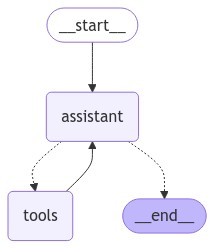

In [44]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [45]:
# import uuid
# import shutil
# from PIL import Image
# from transformers import LlavaForConditionalGeneration, AutoProcessor
# import torch
# import cv2

# multimodal_model = LlavaForConditionalGeneration.from_pretrained(
#     "llava-hf/llava-interleave-qwen-0.5b-hf", torch_dtype=torch.float16
# ).to("cuda")
# processor = AutoProcessor.from_pretrained("llava-hf/llava-interleave-qwen-0.5b-hf")
# input_state = {
#     "messages": "What's happening here?",
#     "media_files": ["causes-of-structural-damage.jpg"]
# }


# thread_id = str(uuid.uuid4())
# config = {
#     "configurable": {
#         "user_id": str(uuid.uuid4()),
#         "thread_id": thread_id,
#     }
# }

# _printed = set()

# def get_user_input():
#     text_input = input("Enter your text description (optional, press enter to skip): ")
#     file_input = input("Enter the file path for the image or video (optional, press enter to skip): ")
#     if not text_input:
#         text_input = "Default building restoration description"

#     # If no file is provided, leave it empty
#     if not file_input:
#         file_input = None

#     # Create the input dictionary, handling optional file
#     user_input = {
#         'text': text_input,
#         'files': [{'path': file_input}] if file_input else []
#     }

#     # Wrap the dictionary in backticks and return it
#     return f"`{user_input}`"

# # Simulate multi-turn conversation using a loop for one question
# while True:
#     # Prompt user for text and file input
#     question = get_user_input()

#     print(f"User: {question}")  
    # events = part_1_graph.stream(
    #     {"messages": ("user", question)}, config, stream_mode="values"
    # )
    
    # for event in events:
    #     _print_event(event, _printed)  # Assuming _print_event handles the event output
    
    # print("-------")  # Divider between each round for clarity
    # question = input("Enter your next question or action: ")


In [46]:
import uuid
import shutil
from PIL import Image
from transformers import LlavaForConditionalGeneration, AutoProcessor
import torch
import cv2
multimodal_model = LlavaForConditionalGeneration.from_pretrained(
    "llava-hf/llava-interleave-qwen-0.5b-hf", torch_dtype=torch.float16
).to("cuda")
processor = AutoProcessor.from_pretrained("llava-hf/llava-interleave-qwen-0.5b-hf")

def get_user_input():
    text_input = input("Enter your text description (optional, press enter to skip): ")
    file_input = input("Enter the file path for the image or video (optional, press enter to skip): ")
    if not text_input:
        text_input = "Default building restoration description"

    # If no file is provided, leave it empty
    if not file_input:
        file_input = None

    user_input = {
        'text': text_input,
        'files': [{'path': file_input}] if file_input else []
    }

    return f"`{user_input}`"

thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        "user_id": str(uuid.uuid4()),
        "thread_id": thread_id,
    }
}

_printed = set()

# Simulate conversation and checkpointing using RedisSaver
with RedisSaver.from_conn_info(host="localhost", port=6379, db=0) as checkpointer:
    graph = builder.compile(checkpointer=checkpointer)

    while True:
        question = get_user_input()
        print(f"User: {question}")
        
        events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
        )
        latest_checkpoint = checkpointer.get(config)
        latest_checkpoint_tuple = checkpointer.get_tuple(config)
        checkpoint_tuples = list(checkpointer.list(config))
        
        for event in events:
            _print_event(event, _printed)  # Assuming _print_event handles the event output
        
        print("-------")  # Divider between each round for clarity


Enter your text description (optional, press enter to skip):  what's really happening here?
Enter the file path for the image or video (optional, press enter to skip):  damage_image.jpg


User: `{'text': "what's really happening here?", 'files': [{'path': 'damage_image.jpg'}]}`
================================ Human Message =================================

`{'text': "what's really happening here?", 'files': [{'path': 'damage_image.jpg'}]}`
================================== Ai Message ==================================
Tool Calls:
  multimodal_inference (call_2Radns0AUhalFrfW3u1PBDyb)
 Call ID: call_2Radns0AUhalFrfW3u1PBDyb
  Args:
    query: {'text': "what's really happening here?", 'files': ['damage_image.jpg']}
================================= Tool Message =================================
Name: multimodal_inference

Error: 1 validation error for multimodal_inference
query.files.0
  Input should be a valid dictionary [type=dict_type, input_value='damage_image.jpg', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/dict_type
 Please fix your mistakes.
================================== Ai Message ==================================


Enter your text description (optional, press enter to skip):  try again
Enter the file path for the image or video (optional, press enter to skip):  damage_image.jpg


User: `{'text': 'try again', 'files': [{'path': 'damage_image.jpg'}]}`
================================ Human Message =================================

`{'text': 'try again', 'files': [{'path': 'damage_image.jpg'}]}`
================================== Ai Message ==================================

It appears there was a misunderstanding in processing your request. Currently, I'm unable to directly analyze image files or videos through this interface. However, you can describe the damage or situation you're facing in text, and I can assist you based on that information. 

Please provide a detailed description of the damage or issue you're encountering, and I'll do my best to assist you.
-------


KeyboardInterrupt: Interrupted by user

In [47]:
latest_checkpoint = checkpointer.get(config)
latest_checkpoint_tuple = checkpointer.get_tuple(config)
checkpoint_tuples = list(checkpointer.list(config))

In [48]:
checkpoint_tuples

[CheckpointTuple(config={'configurable': {'thread_id': '5cce9beb-f486-4b6c-97d3-89a494e432f4', 'checkpoint_ns': '', 'checkpoint_id': '1ef8c622-76fd-6495-8006-bbcf5c4355dc'}}, checkpoint={'v': 1, 'ts': '2024-10-17T08:31:06.809843+00:00', 'id': '1ef8c622-76fd-6495-8006-bbcf5c4355dc', 'channel_values': {'messages': [HumanMessage(content='`{\'text\': "what\'s really happening here?", \'files\': [{\'path\': \'damage_image.jpg\'}]}`', additional_kwargs={}, response_metadata={}, id='67abb24a-812f-49dd-b30c-afd7f4c07476'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2Radns0AUhalFrfW3u1PBDyb', 'function': {'arguments': '{"query":{"text":"what\'s really happening here?","files":["damage_image.jpg"]}}', 'name': 'multimodal_inference'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 968, 'total_tokens': 999, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_detail

In [49]:
latest_checkpoint

{'v': 1,
 'ts': '2024-10-17T08:31:06.809843+00:00',
 'id': '1ef8c622-76fd-6495-8006-bbcf5c4355dc',
 'channel_values': {'messages': [HumanMessage(content='`{\'text\': "what\'s really happening here?", \'files\': [{\'path\': \'damage_image.jpg\'}]}`', additional_kwargs={}, response_metadata={}, id='67abb24a-812f-49dd-b30c-afd7f4c07476'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2Radns0AUhalFrfW3u1PBDyb', 'function': {'arguments': '{"query":{"text":"what\'s really happening here?","files":["damage_image.jpg"]}}', 'name': 'multimodal_inference'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 968, 'total_tokens': 999, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0125-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-60a785b6-